Investigating chirp shape at beginning for each station and season

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    22:19:50 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    22:19:50 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    22:19:50 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
# open client
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42795")
client

<Client: 'tcp://127.0.0.1:42795' processes=4 threads=16, memory=125.81 GiB>

Task exception was never retrieved
future: <Task finished name='Task-5344' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit


In [4]:
# define function to use portion of chirp
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

# function to plot chirp histograms
def plot_hist(ds,ylim=False):
    atten_count = len(ds.attenuator_setting_pair)
    fig, axs = plt.subplots(ncols=atten_count,figsize=(5*atten_count,5))
    
    for i in range(atten_count):
        ds.chirp.isel(attenuator_setting_pair=i).mean(dim='chirp_num').plot.hist(ax=axs[i],bins=100)
        axs[i].set_title(f'G = {int(ds.AFGain[i].values)} dB, A = {int(ds.attenuator[i].values)} dB')
        axs[i].set_ylabel('count')
        axs[i].set_xlabel('chirp voltage [V]')
        if ylim:
            old_lim = axs[i].get_ylim()
            axs[i].set_ylim([old_lim[0],old_lim[1]*0.2])

def plot_amplitude_trends(ds):
    atten_count = len(ds.attenuator_setting_pair)
    fig, axs = plt.subplots(nrows=3,ncols=atten_count,figsize=(5*atten_count,15))
    for i in range(atten_count):
        # Over chirp 
        abs(ds.isel(attenuator_setting_pair = i).chirp).max(dim=['chirp_num','time'])[1:-1].plot(ax=axs[0][i],linestyle='None',marker='.',label='max')
        abs(ds.isel(attenuator_setting_pair = i).chirp).mean(dim=['chirp_num','time'])[1:-1].plot(ax=axs[0][i],linestyle='None',marker='.',label='mean')
        axs[0][i].set_title(f'G = {int(ds.AFGain[i].values)} dB, A = {int(ds.attenuator[i].values)} dB')
        axs[0][i].set_ylabel('')
        axs[0][i].set_xlabel('chirp time')
        axs[0][i].legend()

        # Over chirp number 
        abs(ds.isel(attenuator_setting_pair = i).chirp).max(dim=['chirp_time','time']).plot(ax=axs[1][i],linestyle='None',marker='.',label='max')
        abs(ds.isel(attenuator_setting_pair = i).chirp).mean(dim=['chirp_time','time']).plot(ax=axs[1][i],linestyle='None',marker='.',label='mean')
        axs[1][i].set_ylabel('')
        axs[1][i].set_xlabel('chirp number')
        axs[1][i].set_title('')

        # over burst time
        abs(ds.isel(attenuator_setting_pair = i).chirp).max(dim=['chirp_time','chirp_num']).plot(ax=axs[2][i],linestyle='None',marker='.',label='max')
        abs(ds.isel(attenuator_setting_pair = i).chirp).mean(dim=['chirp_time','chirp_num']).plot(ax=axs[2][i],linestyle='None',marker='.',label='mean')
        axs[2][i].set_ylabel('')
        axs[2][i].set_xlabel('date')
        axs[2][i].set_title('')
    
    axs[0][0].set_ylabel('chirp magnitude over chirp time [V]')
    axs[1][0].set_ylabel('chirp magnitude over chirp number [V]')
    axs[2][0].set_ylabel('burst magnitude over time [V]')

def plot_bad_chirp_count(ds):
    # input ds should be the form of ds.isel(attenuator_setting_pair=i).chirp.where(condition)
    fig, axs = plt.subplots(ncols=3,figsize=(15,5),layout='tight')
    ds.count(dim=['chirp_num','time']).plot(ax=axs[0],linestyle='None',marker='.')
    axs[0].set_ylabel('count')
    axs[0].set_title('Total instances of clipping in chirp section')
    
    (ds.max(dim='chirp_time').count(dim='time')/(ds.max(dim='chirp_time').count())).plot(ax=axs[1],linestyle='None',marker='.')
    axs[1].set_ylabel('fraction of total clipped chirps')
    axs[1].set_title('Clipped chirp distribution by chirp number')
    
    ds.max(dim='chirp_time').count(dim='chirp_num').plot(ax=axs[2],linestyle='None',marker='.')
    axs[2].set_ylabel('count')
    axs[2].set_title('Number of chirps with clipping in each burst')

def plot_profile(example_chirp):
    fig, axs = plt.subplots(ncols=2,figsize=(10,5))
    for i in [0,1]:
        example_chirp.isel(attenuator_setting_pair = i).chirp.mean(dim='chirp_num').plot(ax=axs[0],label = f'G = {int(example_chirp.AFGain[i].values)} dB, A = {int(example_chirp.attenuator[i].values)} dB')
        xa.dB(example_chirp.isel(attenuator_setting_pair = i).profile_stacked).plot(ax=axs[1])
    axs[0].legend()
    axs[0].set_title('Chirp')
    axs[0].set_ylabel('voltage [V]')
    axs[0].set_xlabel('chirp time [ns]')
    
    axs[1].set_title('Profile')
    axs[1].set_ylabel('reflector amplitude [dB]')
    axs[0].set_xlabel('range [m]')

# Repurpose another function to compare strain rate estimates based on window
def generate_strain_fit(ds,window,lag,lims=None):
    # New method
    profile = ds.profile_stacked.isel(attenuator_setting_pair=0).compute()
    b1= profile.isel(time=range(0,len(profile)-lag))
    b2 = profile.isel(time=range(lag,len(profile)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    
    # Old Method
    profile = custom_stacked_profile_series(ds.chirp.isel(attenuator_setting_pair=0,chirp_num=range(10,20)),2)
    b1= profile.isel(time=range(0,len(profile)-lag))
    b2 = profile.isel(time=range(lag,len(profile)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_old = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')
    vv_old = ds_old.range_diff / ds_old.time_diff * 31536000
    vv_old_err = ds_old.err / ds_old.time_diff * 31536000
    fit_old=vv_old.where(vv_old.profile_range <=600).polyfit('profile_range',1,full=True)
    r2_old = 1-fit_old.polyfit_residuals/((vv_old-vv_old.mean())**2).sum(dim='profile_range')
    
    # Plotting
    fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',label='Chirps 1-20')
    axs[0].plot(fit_old.time.values,fit_old.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',alpha=0.2,label='Chirps 10-20')
    #axs[0].set_ylim([-1e-2,1e-2])
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain fitting results')
    axs[0].legend(loc="upper left", ncol=2)
    axs[0].set_ylim([-0.01, 0])

    axs[1].plot(fit.time.values,r2.values,linestyle='None',marker='.')
    axs[1].plot(fit_old.time.values,r2_old.values,linestyle='None',marker='.',alpha=0.2)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('r$^2$')
    
    fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
    #fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
    vv_times = np.arange(math.ceil(0.05*len(vv_old.time)),len(vv_old.time),len(vv_old.time)//10)
    for i in range(10):
        time = vv_old.time.isel(time = vv_times[i]).values
        axs_1[i].errorbar(vv.sel(time = time,method="nearest") ,vv.profile_range,yerr=None,xerr=vv_err.sel(time = time,method="nearest"),linestyle='None',marker='.',zorder=1)
        axs_1[i].errorbar(vv_old.sel(time = time,method="nearest") ,vv_old.profile_range,yerr=None,xerr=vv_old_err.sel(time = time,method="nearest"),linestyle='None',marker='.',zorder=2)
        #slope = fit.polyfit_coefficients.sel(degree=1).isel(time=vv_times[i]).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=vv_times[i]).values

        #axs_1[i].plot(slope,np.linspace(20,600),color='r',zorder=2)
        unit = ''#'x10$^{-3}$ yr$^{-1}$'
        #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
        axs_1[i].set_title(f'{time.astype(str)[:10]}')
        if lims:
            axs_1[i].set_xlim(lims)
        axs_1[i].set_ylim([20,1400])
        axs_1[i].tick_params(axis='both', which='major', labelsize=14)


    axs_1[0].invert_yaxis()

    axs_1[0].set_ylabel('depth [m]',fontsize=18)
    fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)
    return vv,vv_err,vv_old,vv_old_err

## A11

### Summer 2022

In [11]:
ds = ds_101
mean_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).mean(dim=['chirp_num','time']).compute()
std_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).std(dim=['chirp_num','time']).compute()

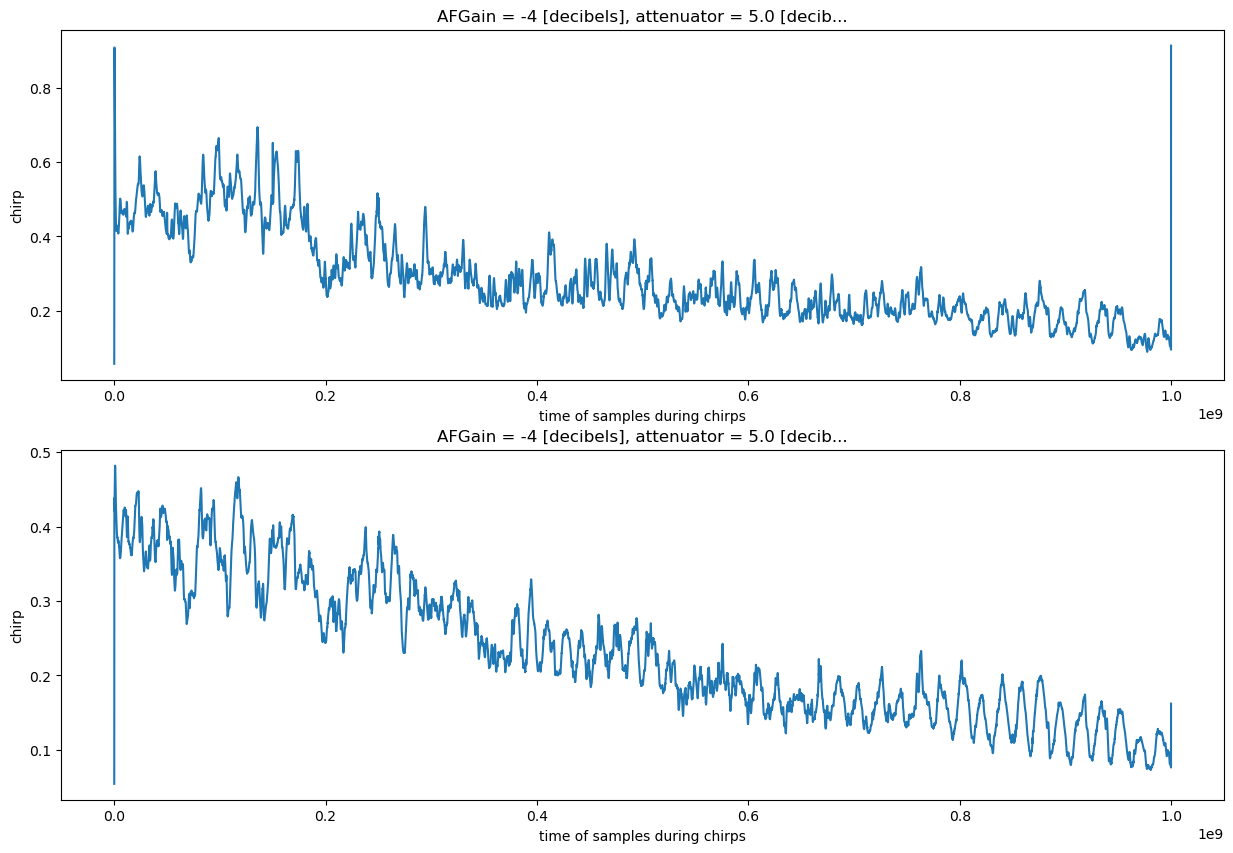

In [12]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.plot(ax=axs[0])
std_chirp_amplitude.plot(ax=axs[1])

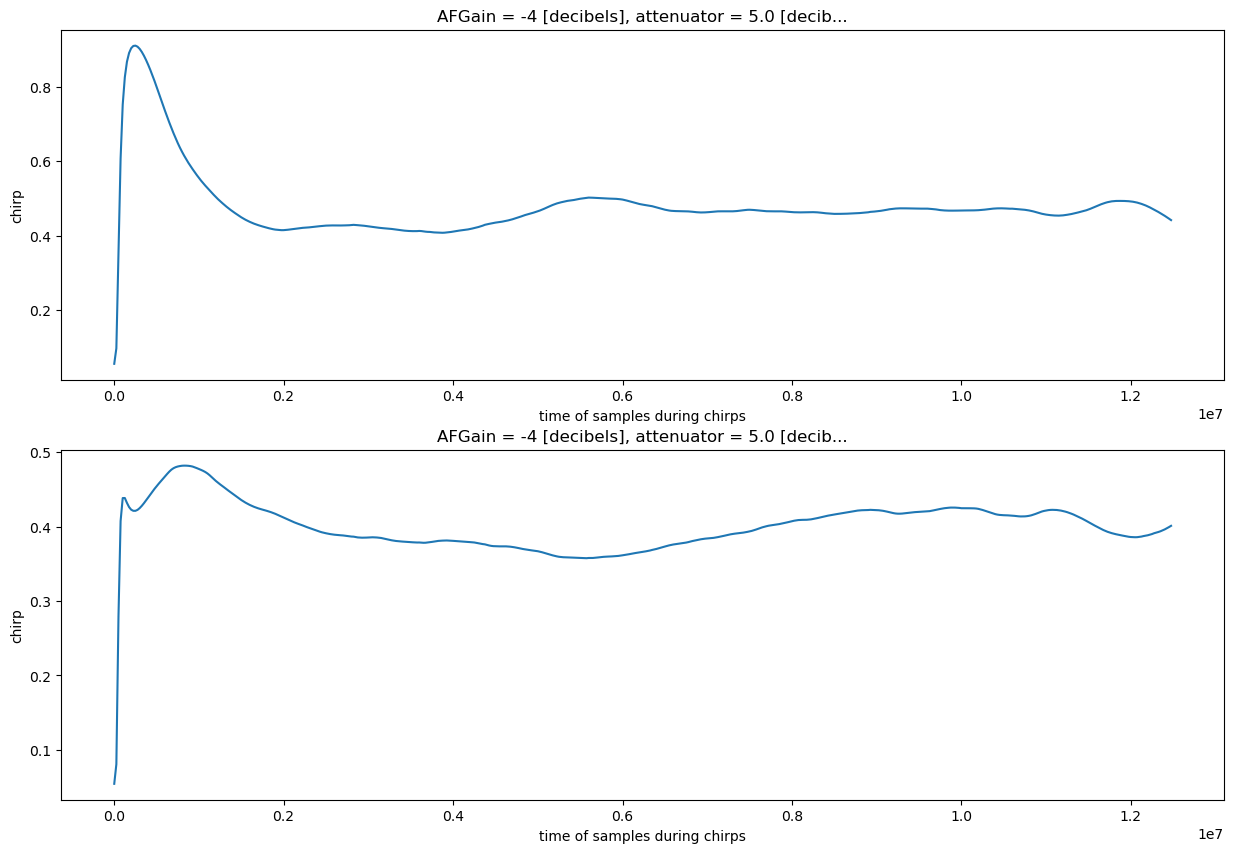

In [13]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[0])
std_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[1])

Dropping first 200 samples probs ok?

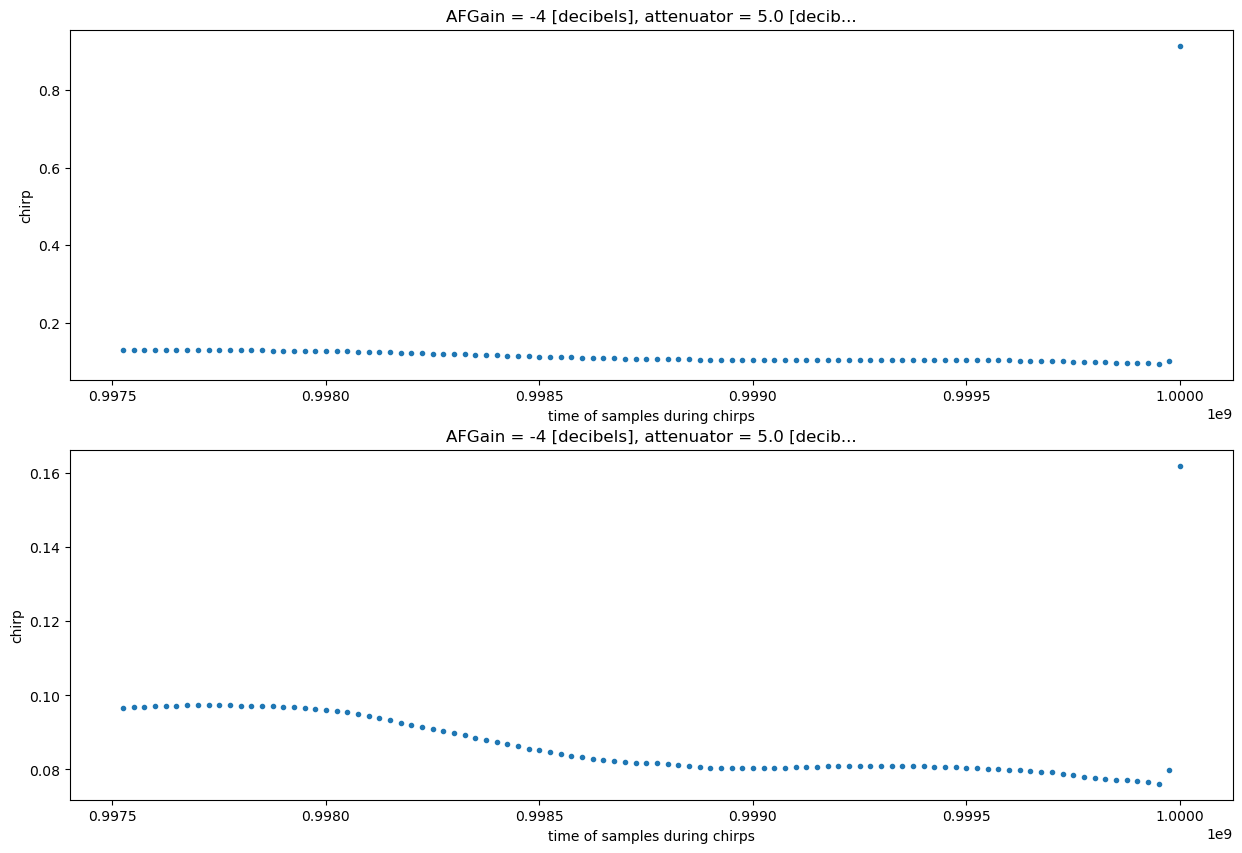

In [15]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))
length = len(mean_chirp_amplitude.chirp_time)
mean_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[0],linestyle='None',marker='.')
std_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[1],linestyle='None',marker='.')

Dropping last one good

## Winter

In [16]:
ds = ds_101_w
mean_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).mean(dim=['chirp_num','time']).compute()
std_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).std(dim=['chirp_num','time']).compute()

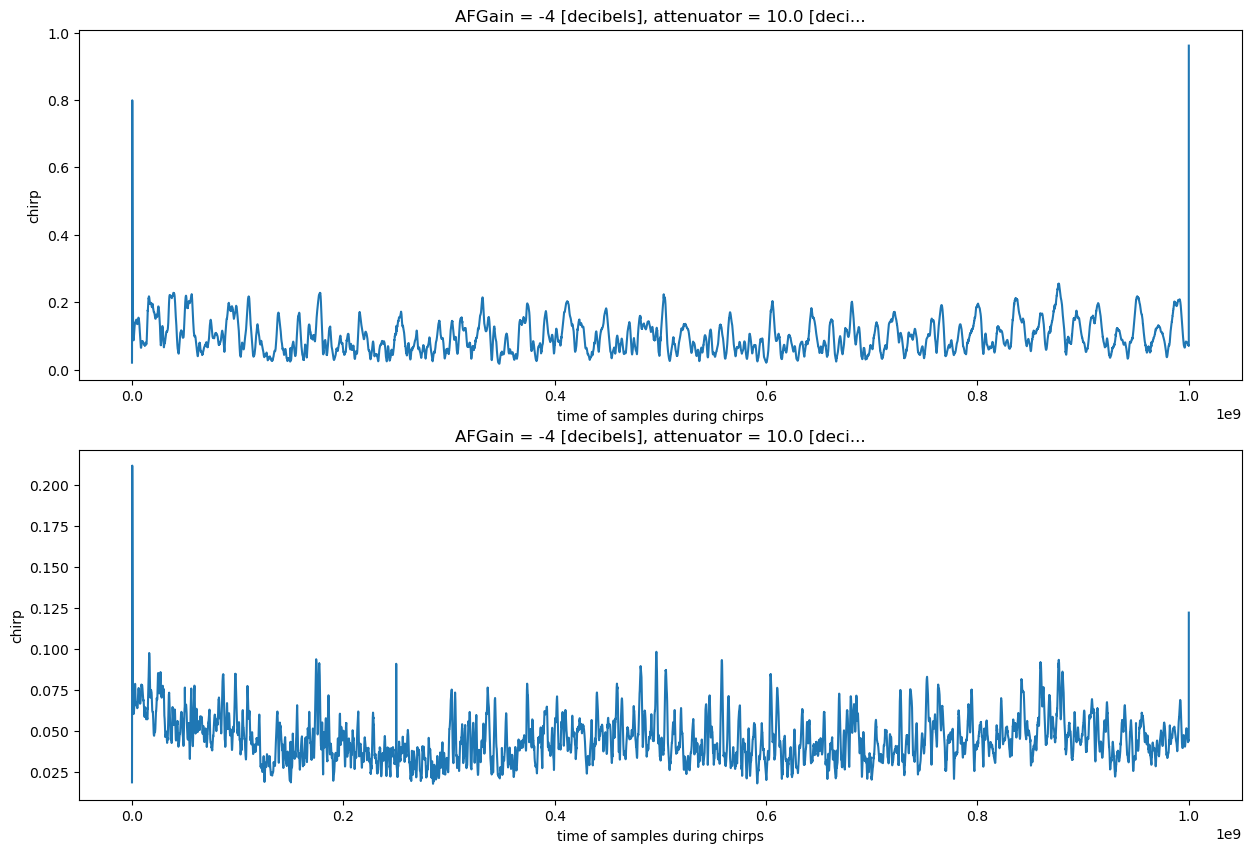

In [17]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.plot(ax=axs[0])
std_chirp_amplitude.plot(ax=axs[1])

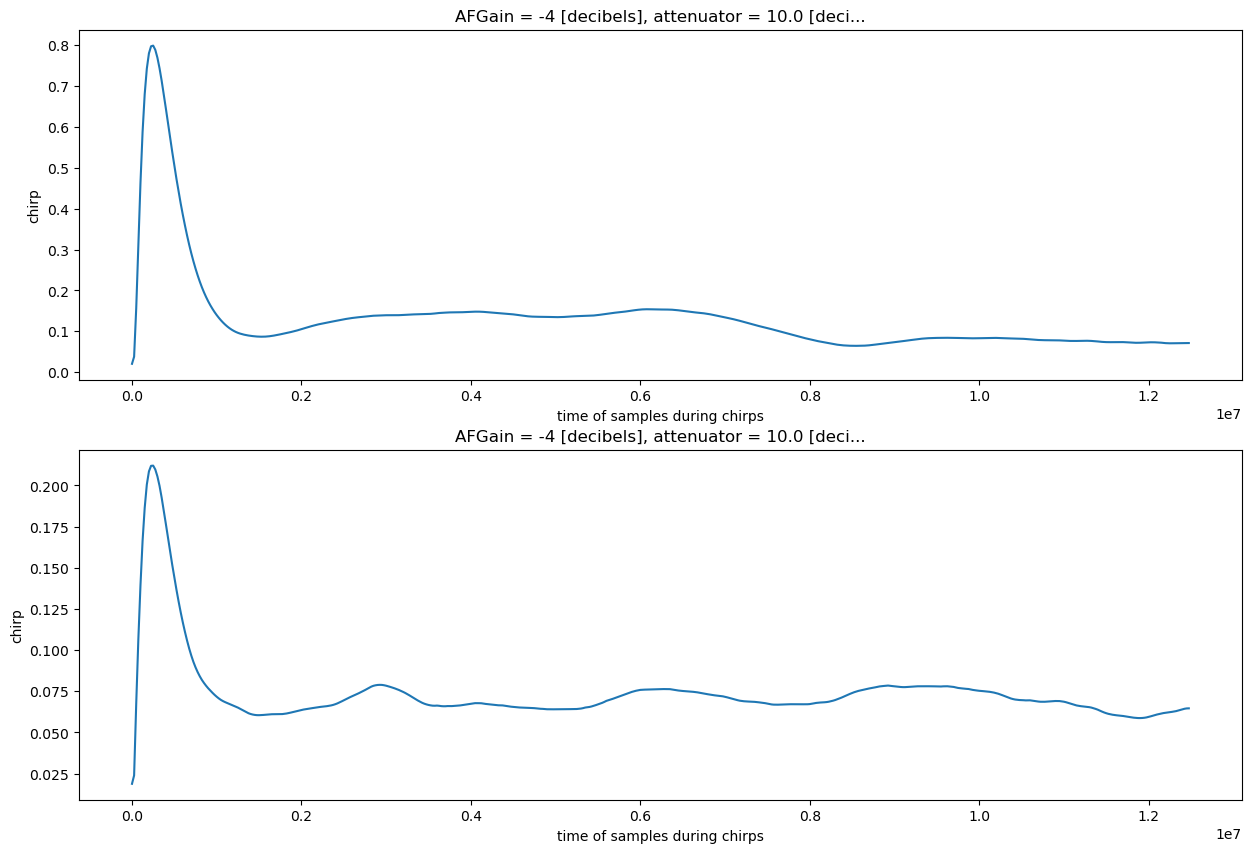

In [18]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[0])
std_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[1])

Dropping first 200 samples probs ok?

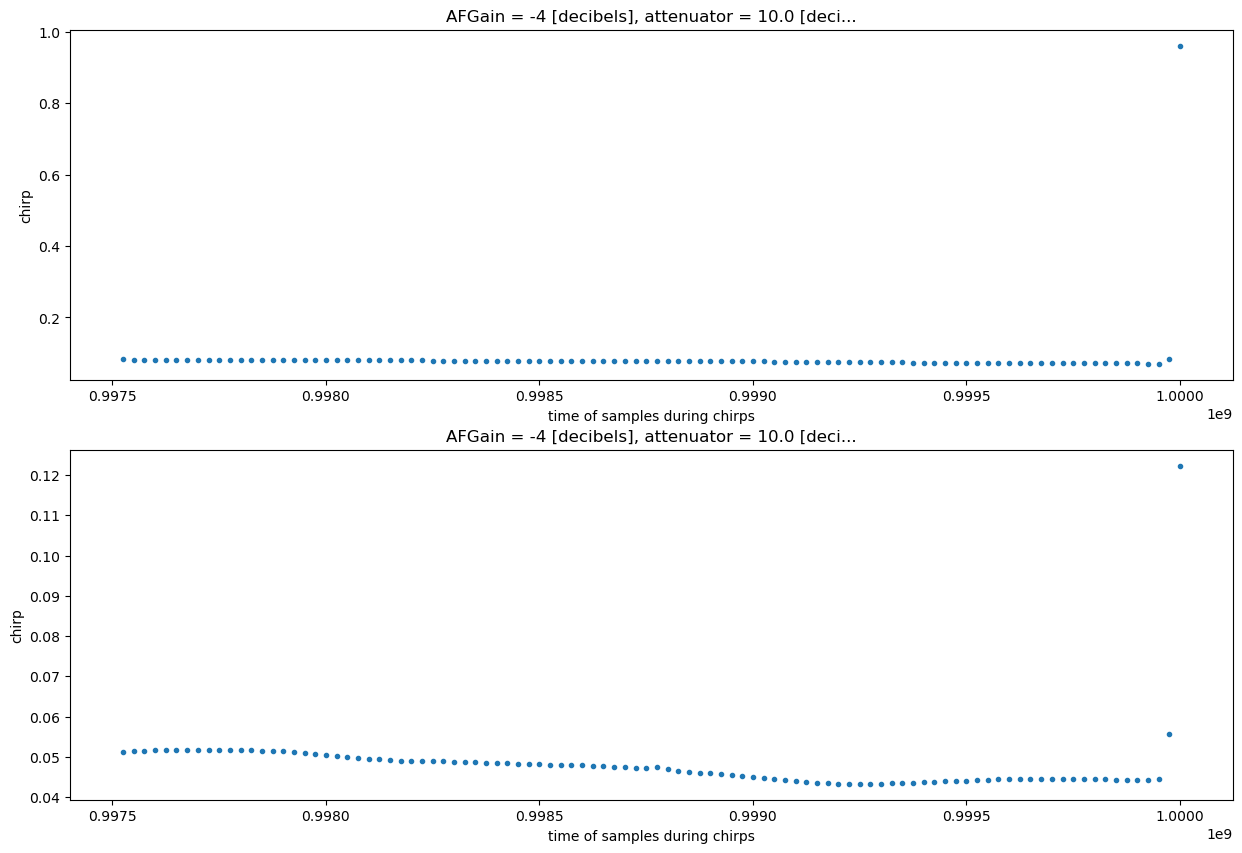

In [19]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))
length = len(mean_chirp_amplitude.chirp_time)
mean_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[0],linestyle='None',marker='.')
std_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[1],linestyle='None',marker='.')

Dropping last one good

## A13

### Summer 2022

In [20]:
ds = ds_103
mean_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).mean(dim=['chirp_num','time']).compute()
std_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).std(dim=['chirp_num','time']).compute()

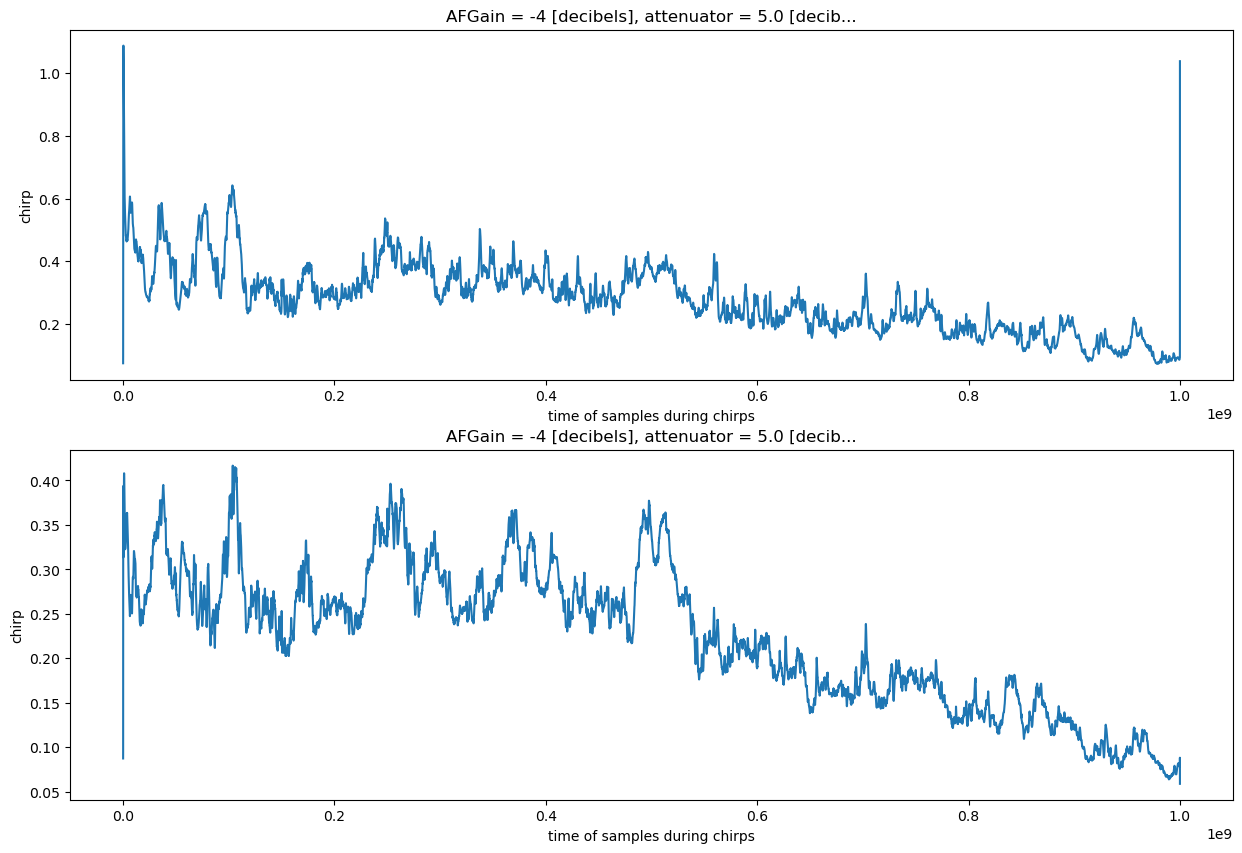

In [21]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.plot(ax=axs[0])
std_chirp_amplitude.plot(ax=axs[1])

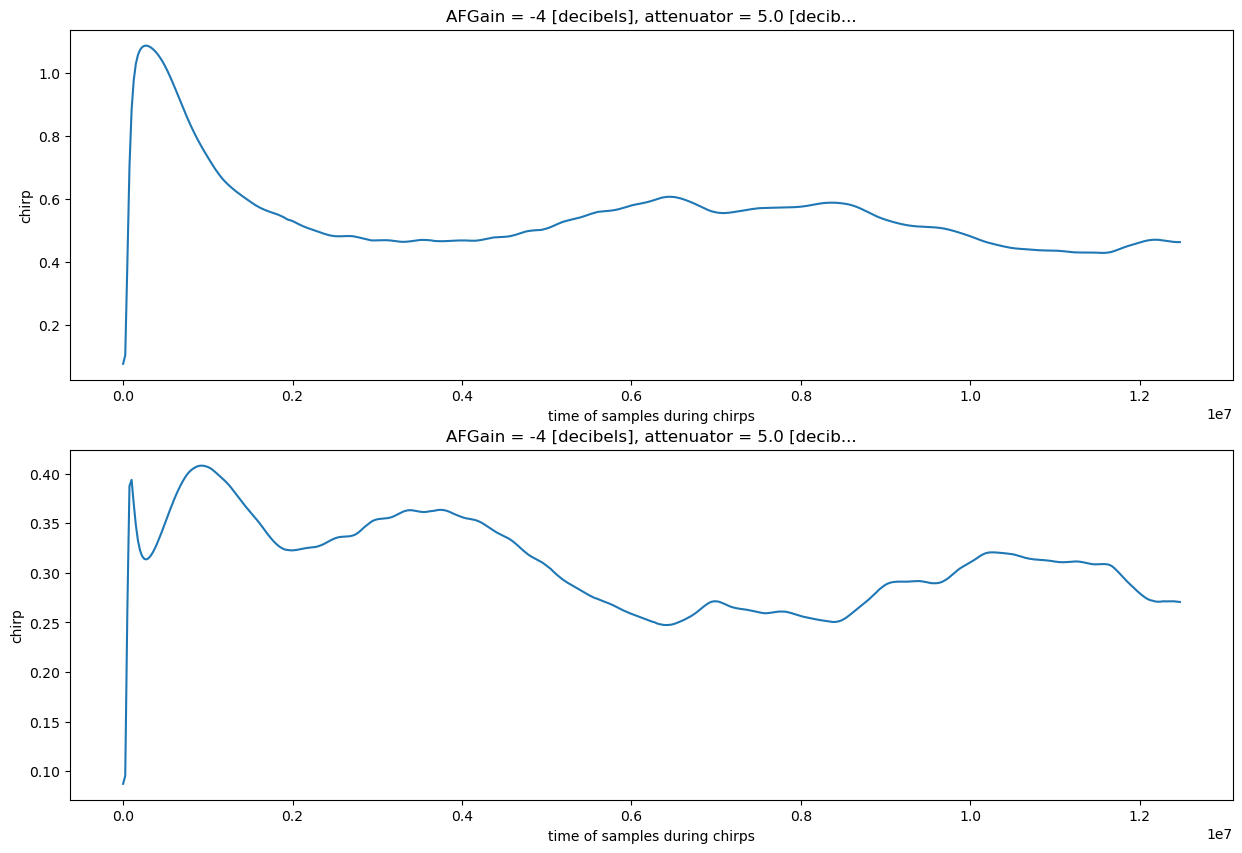

In [22]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[0])
std_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[1])

Dropping first 200 samples probs ok?

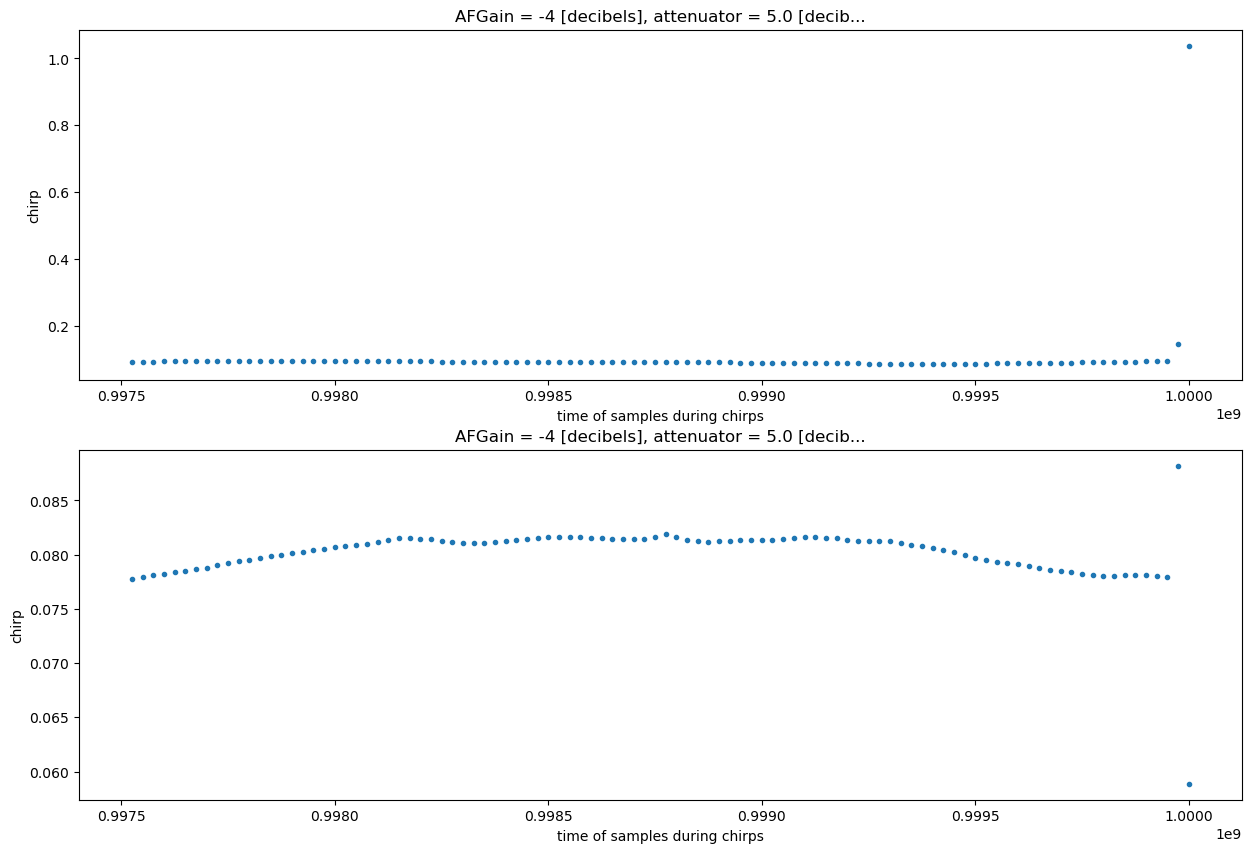

In [23]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))
length = len(mean_chirp_amplitude.chirp_time)
mean_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[0],linestyle='None',marker='.')
std_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[1],linestyle='None',marker='.')

Dropping last one good

## Winter

In [24]:
ds = ds_103_w
mean_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).mean(dim=['chirp_num','time']).compute()
std_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).std(dim=['chirp_num','time']).compute()

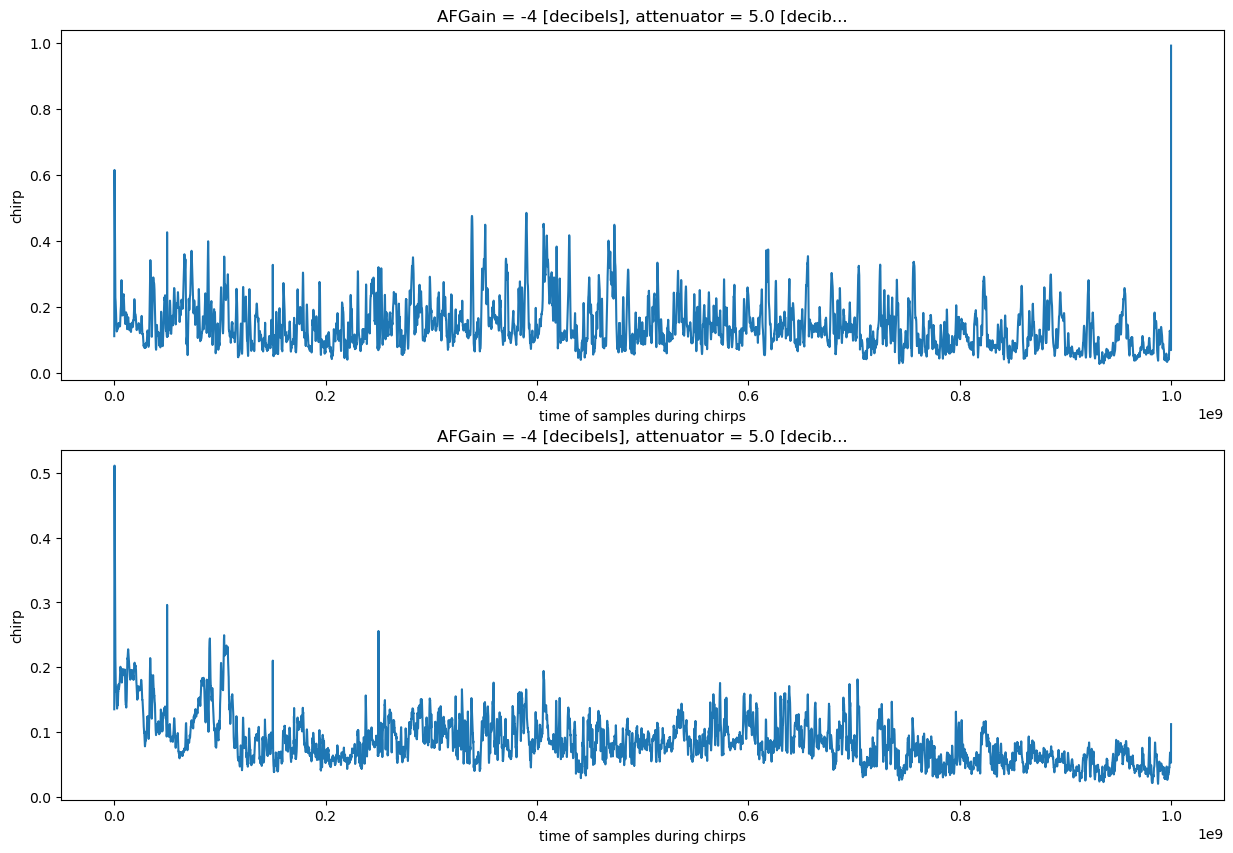

In [25]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.plot(ax=axs[0])
std_chirp_amplitude.plot(ax=axs[1])

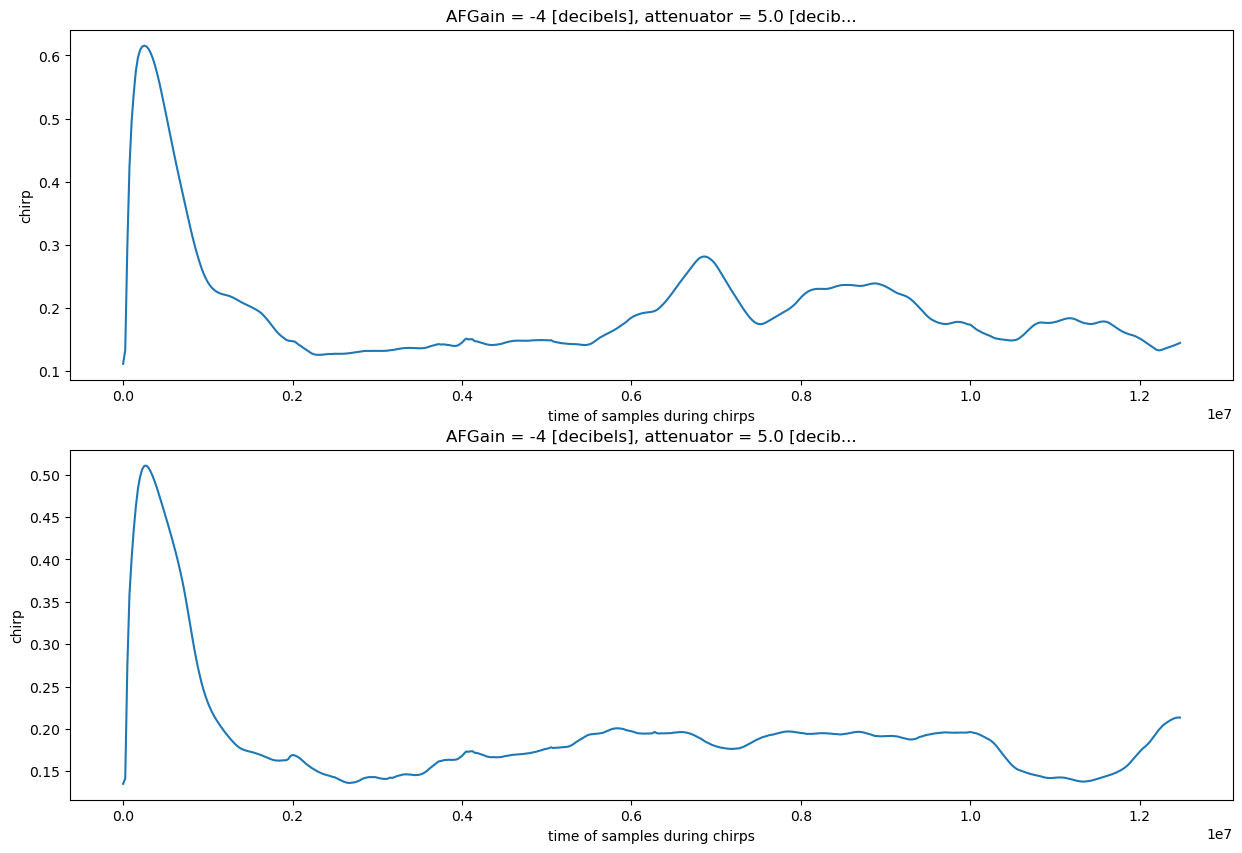

In [26]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[0])
std_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[1])

Dropping first 200 samples probs ok?

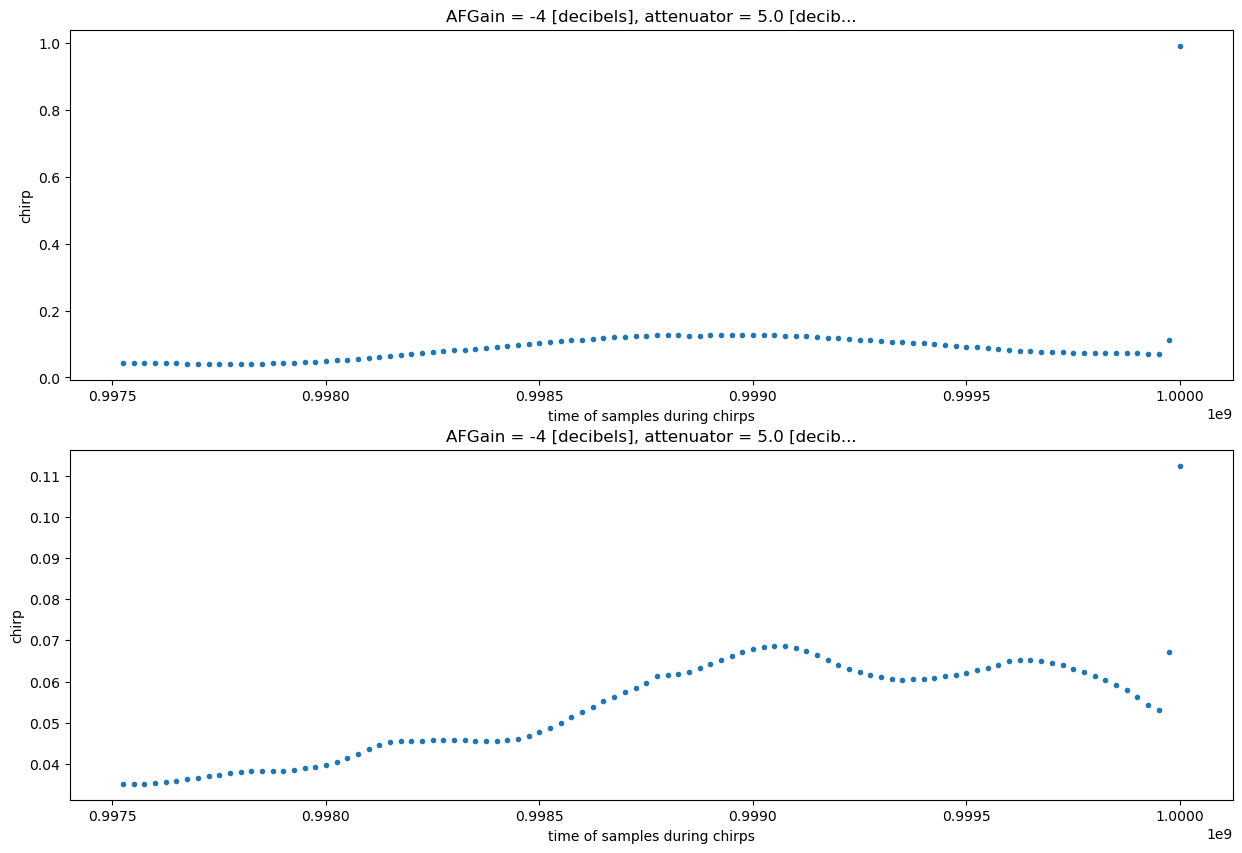

In [27]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))
length = len(mean_chirp_amplitude.chirp_time)
mean_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[0],linestyle='None',marker='.')
std_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[1],linestyle='None',marker='.')

Dropping last one good

## Summer 2023

In [28]:
ds = ds_101_s
mean_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).mean(dim=['chirp_num','time']).compute()
std_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).std(dim=['chirp_num','time']).compute()

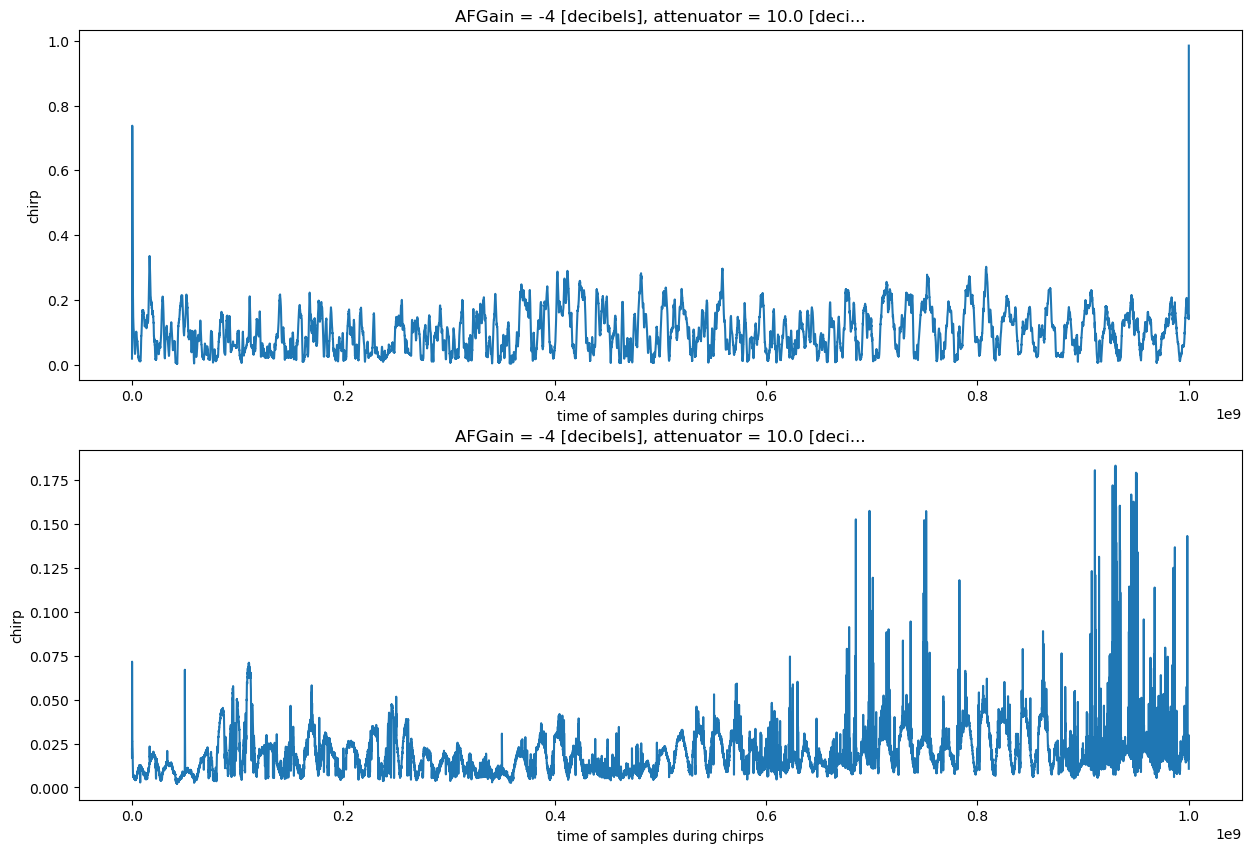

In [29]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.plot(ax=axs[0])
std_chirp_amplitude.plot(ax=axs[1])

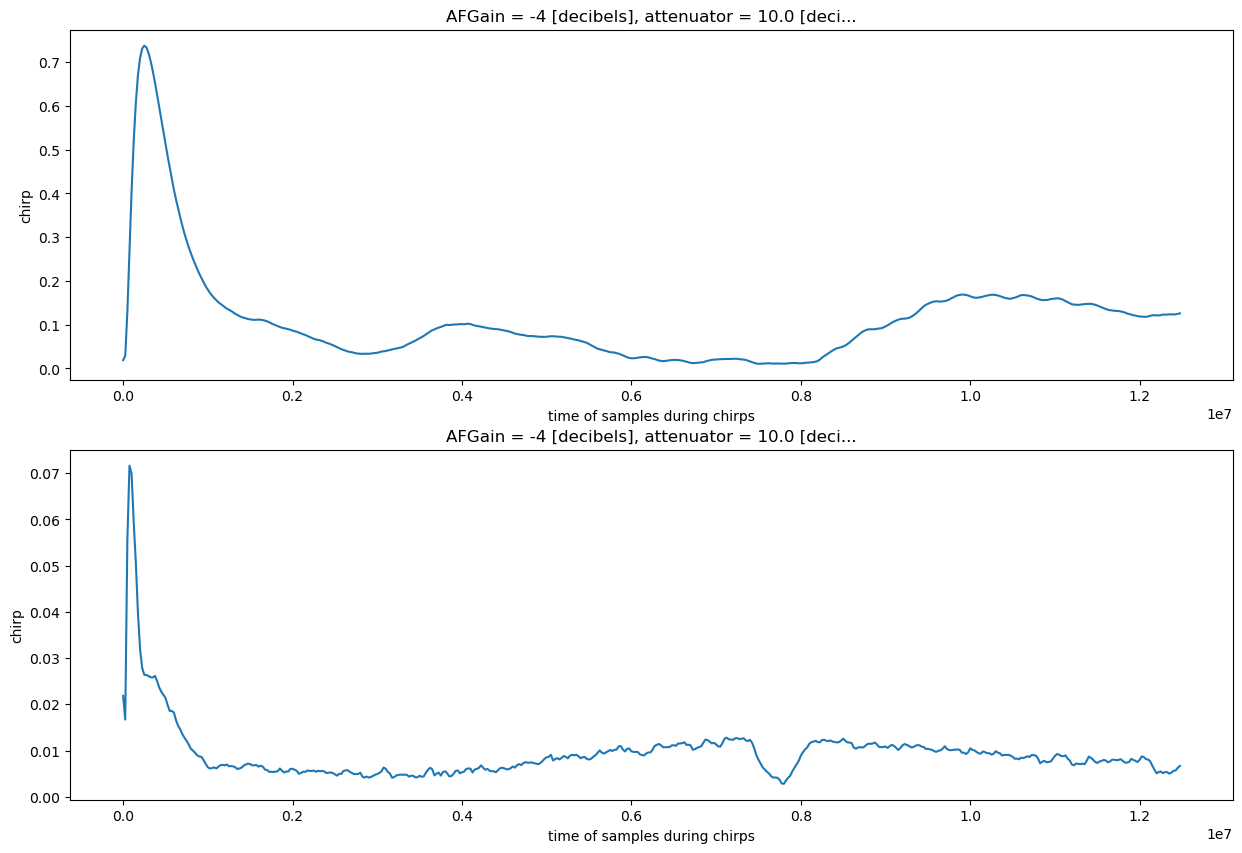

In [30]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[0])
std_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[1])

Dropping first 200 samples probs ok?

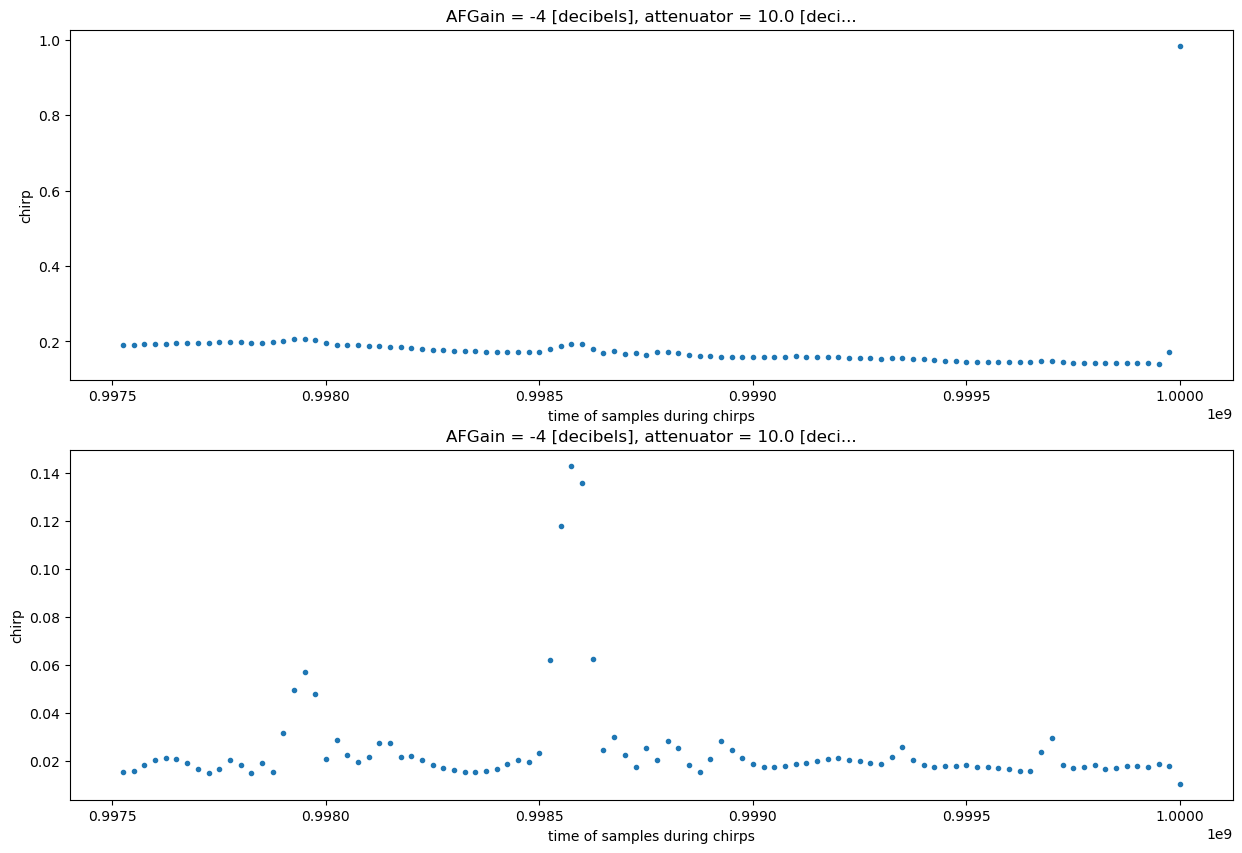

In [31]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))
length = len(mean_chirp_amplitude.chirp_time)
mean_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[0],linestyle='None',marker='.')
std_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[1],linestyle='None',marker='.')

Dropping last one good

## A14

### Summer 2022

In [32]:
ds = ds_104
mean_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).mean(dim=['chirp_num','time']).compute()
std_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).std(dim=['chirp_num','time']).compute()

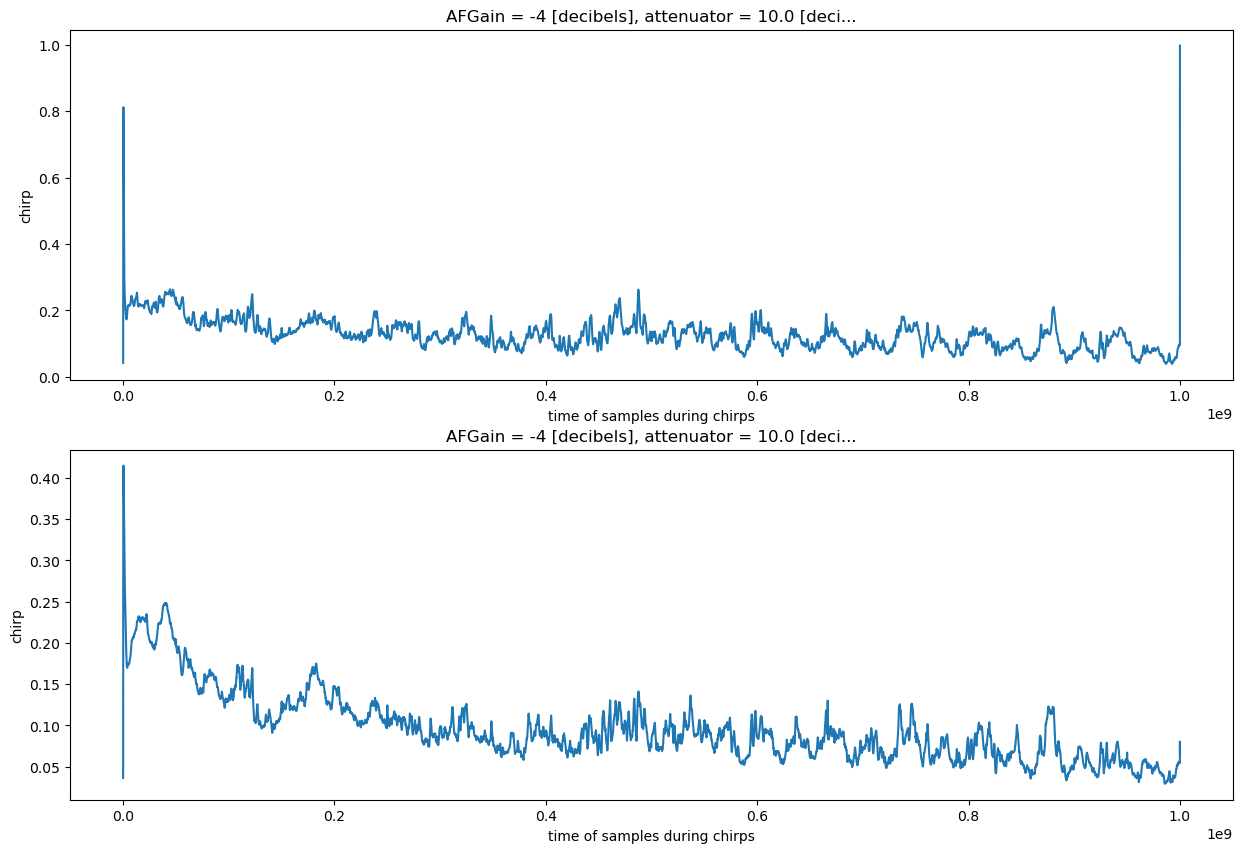

In [33]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.plot(ax=axs[0])
std_chirp_amplitude.plot(ax=axs[1])

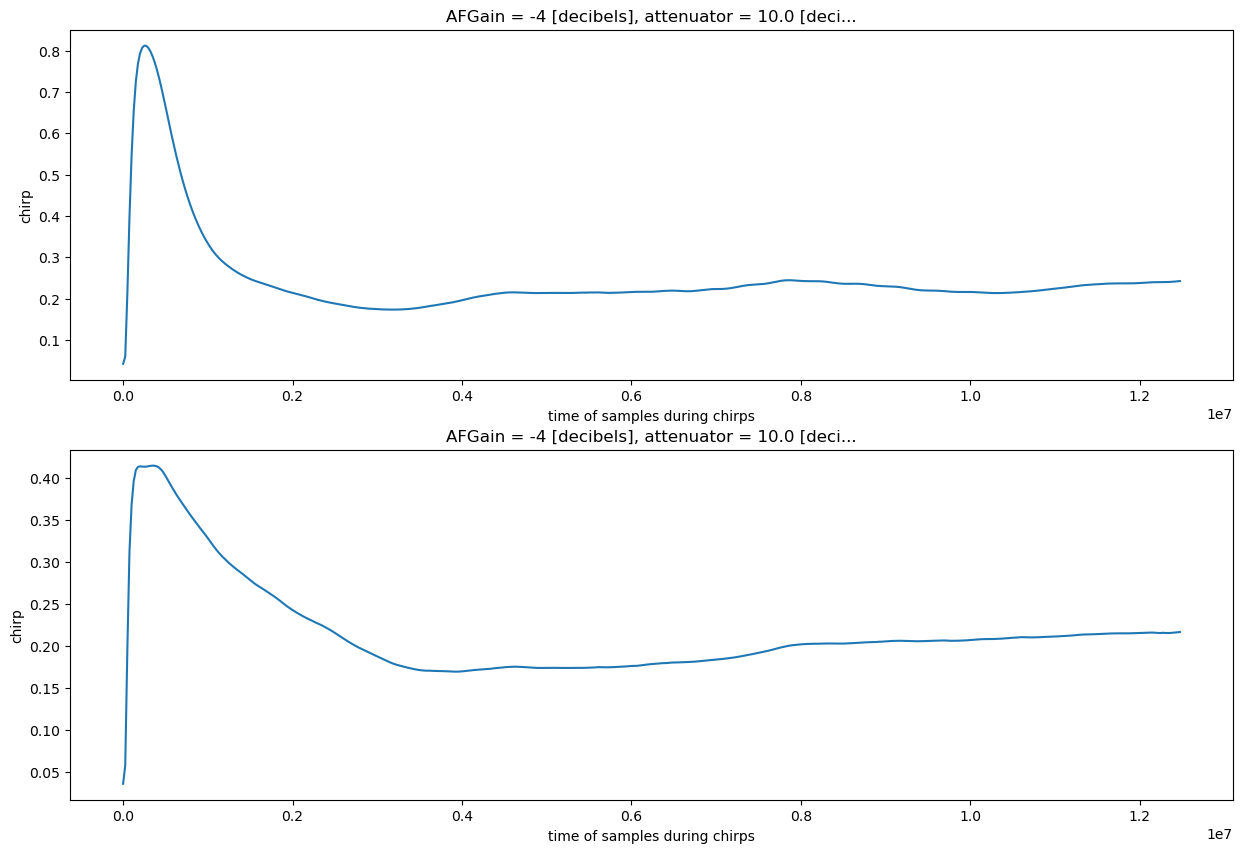

In [34]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[0])
std_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[1])

Dropping first 200 samples probs ok?

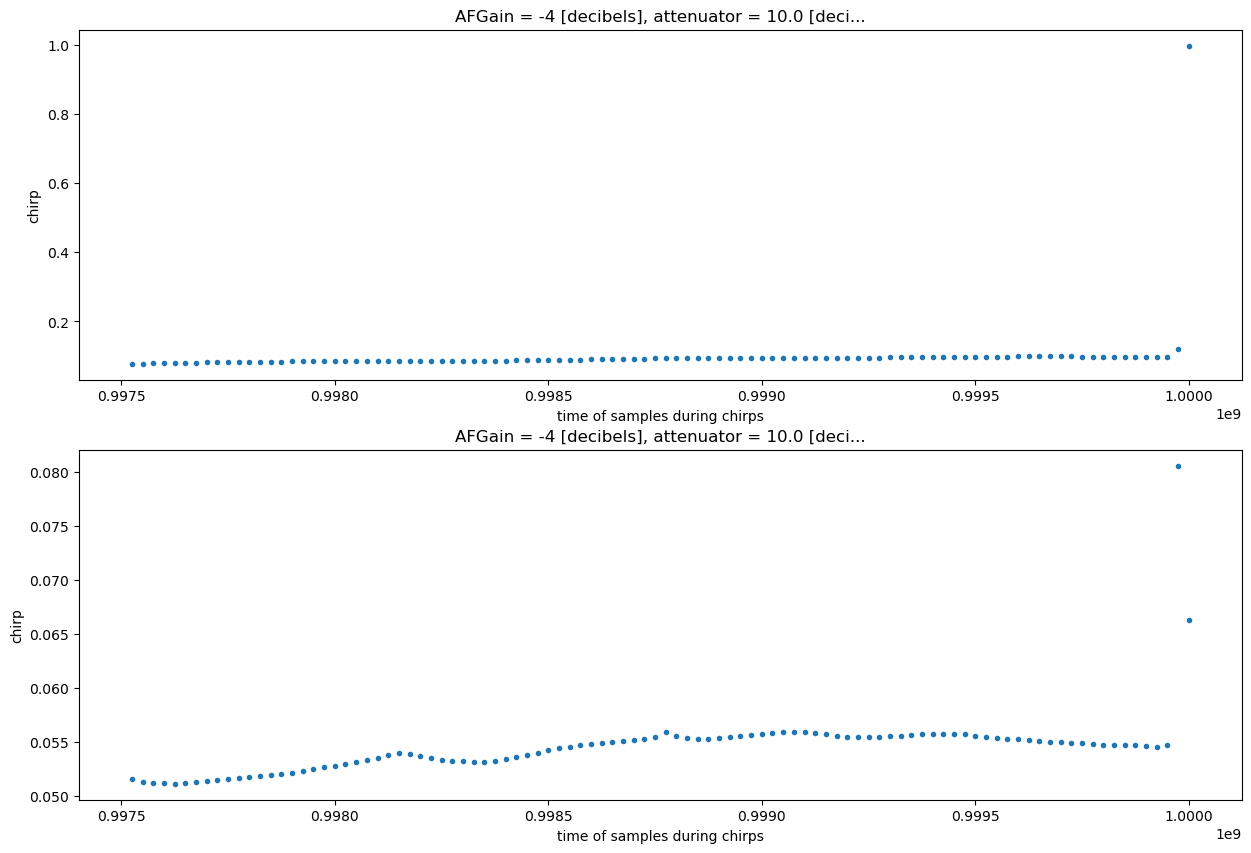

In [35]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))
length = len(mean_chirp_amplitude.chirp_time)
mean_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[0],linestyle='None',marker='.')
std_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[1],linestyle='None',marker='.')

Dropping last one good

## Winter

In [36]:
ds = ds_104_w
mean_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).mean(dim=['chirp_num','time']).compute()
std_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).std(dim=['chirp_num','time']).compute()

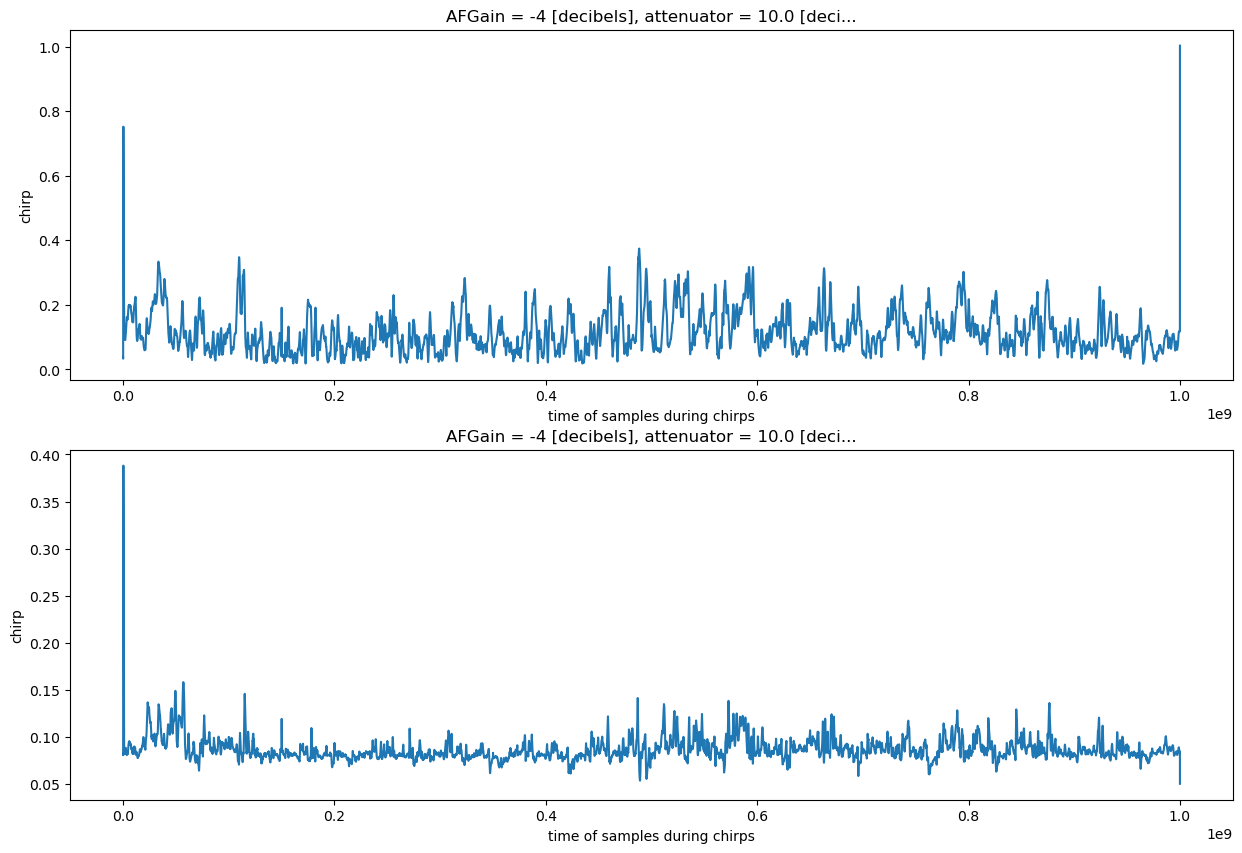

In [37]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.plot(ax=axs[0])
std_chirp_amplitude.plot(ax=axs[1])

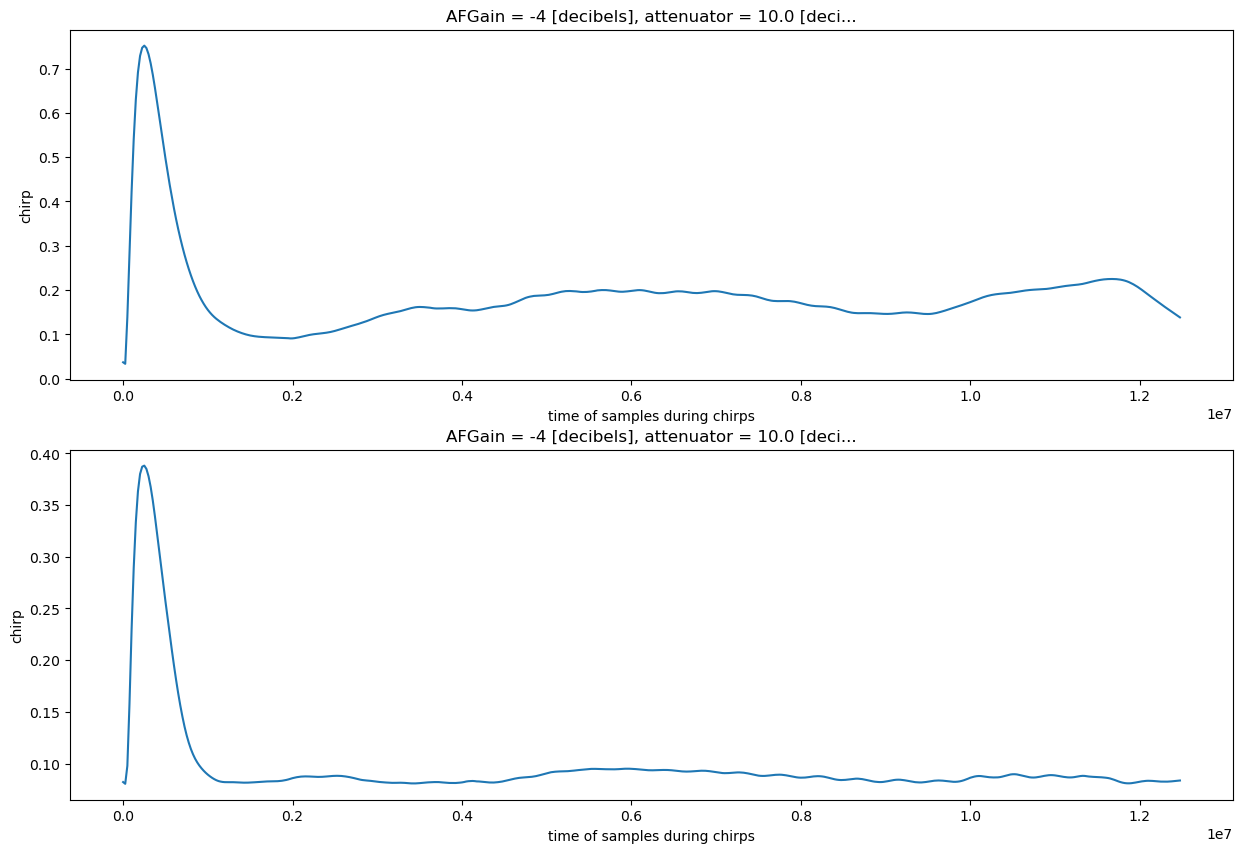

In [38]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[0])
std_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[1])

Dropping first 200 samples probs ok?

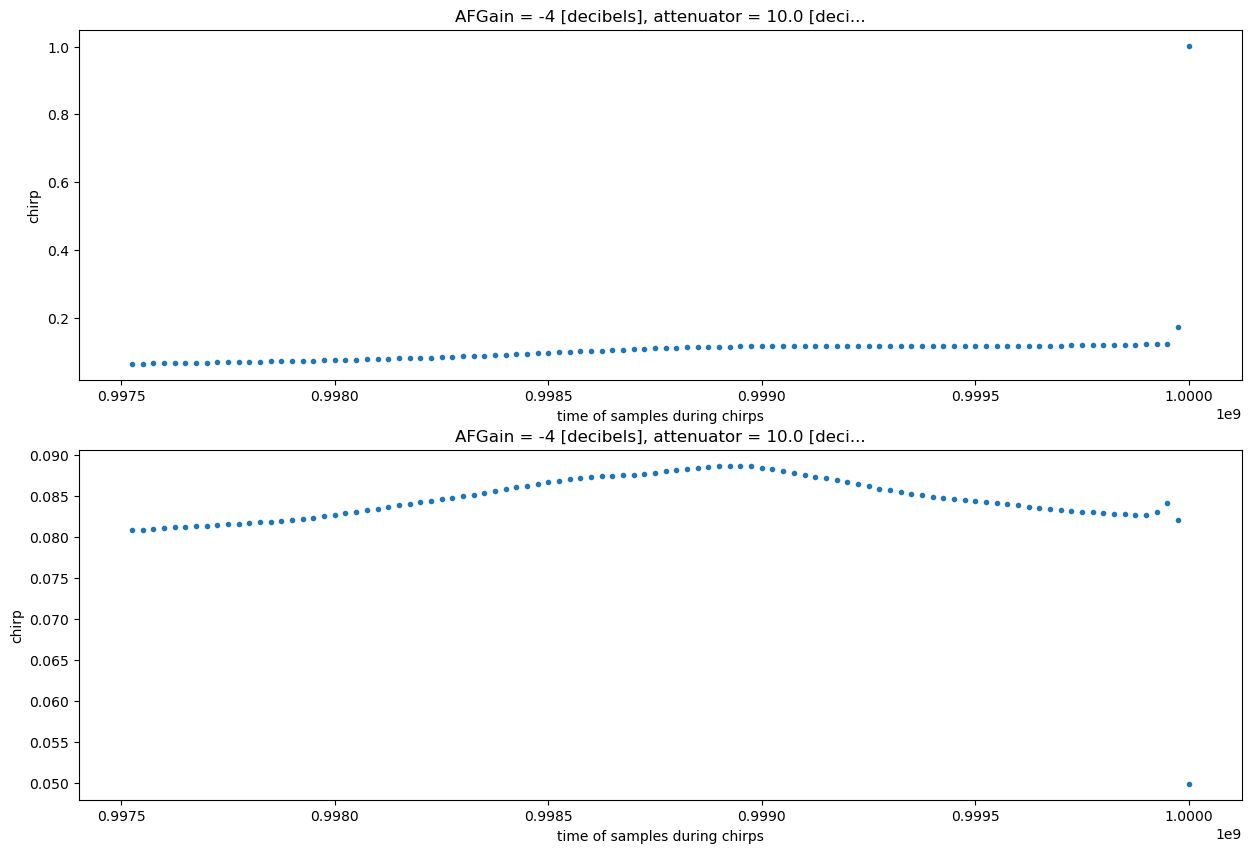

In [39]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))
length = len(mean_chirp_amplitude.chirp_time)
mean_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[0],linestyle='None',marker='.')
std_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[1],linestyle='None',marker='.')

Dropping last one good

## Summer 2024

In [40]:
ds = ds_104_s
mean_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).mean(dim=['chirp_num','time']).compute()
std_chirp_amplitude = abs(ds.chirp.isel(attenuator_setting_pair = 0)).std(dim=['chirp_num','time']).compute()

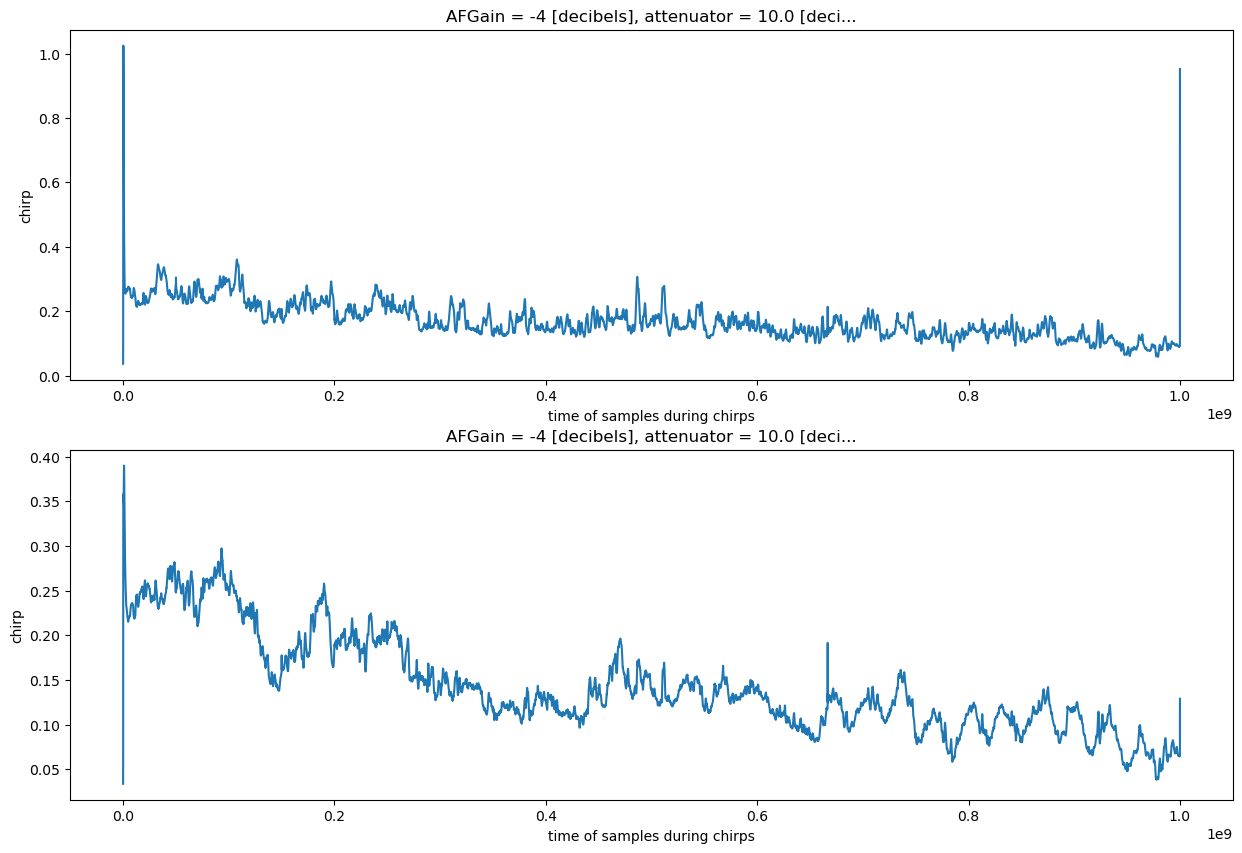

In [41]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.plot(ax=axs[0])
std_chirp_amplitude.plot(ax=axs[1])

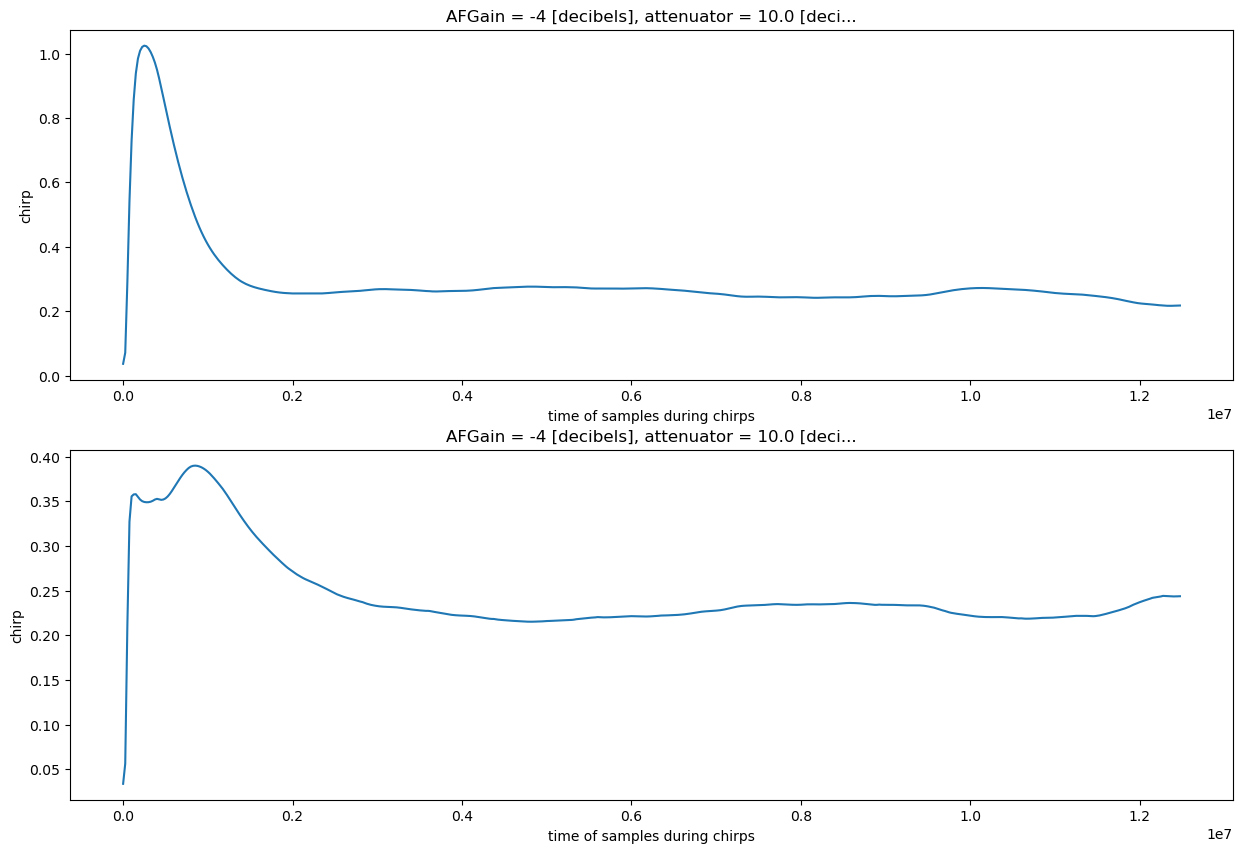

In [42]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))

mean_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[0])
std_chirp_amplitude.isel(chirp_time=range(500)).plot(ax=axs[1])

Dropping first 200 samples probs ok?

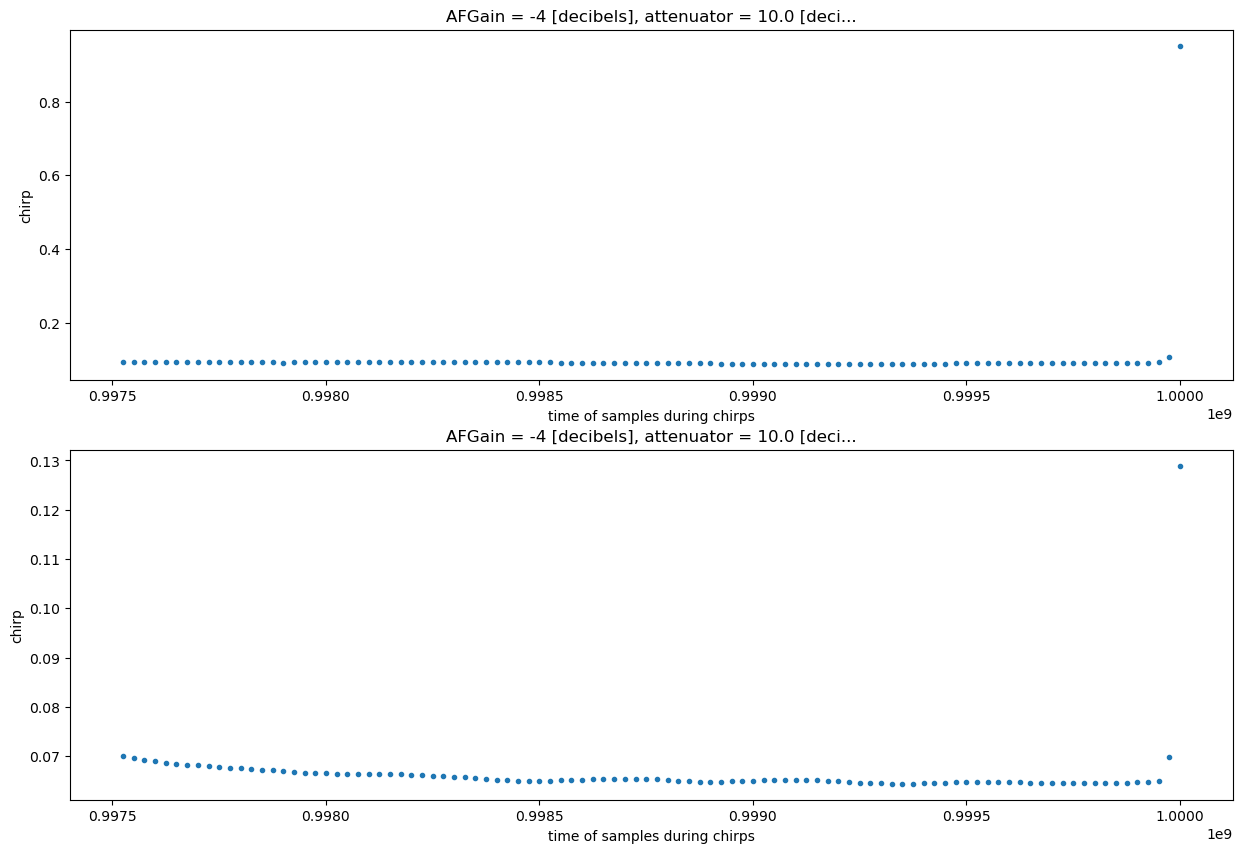

In [43]:
fig,axs = plt.subplots(nrows=2,figsize=(15,10))
length = len(mean_chirp_amplitude.chirp_time)
mean_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[0],linestyle='None',marker='.')
std_chirp_amplitude.isel(chirp_time=range(length-100,length)).plot(ax=axs[1],linestyle='None',marker='.')

Dropping last one good